**Credit Card Fraud**

Começamos por importar os dados e verificar algumas das suas variáveis.

In [1]:
import pandas as pd
import numpy as np

creditCard_data = pd.read_csv('card_transdata.csv')
creditCard_data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


Depois substituímos valores inexistentes por 'NA' de forma a serem 'standardizados', fazemos describe e verificamos que o count é igual a todas as colunas logo não será preciso lidar com valores omitidos ou inexistentes.

In [2]:
creditCard_data = pd.read_csv('card_transdata.csv', na_values = ['NA'])

In [3]:
creditCard_data.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


De forma a poder analisar melhor os dados apresentados decidimos fazer um pair plot. 
De forma a acelerar o processamento do desenho destes analisamos apenas 20%.

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sb

creditCard_data = pd.read_csv('card_transdata20.csv')

''

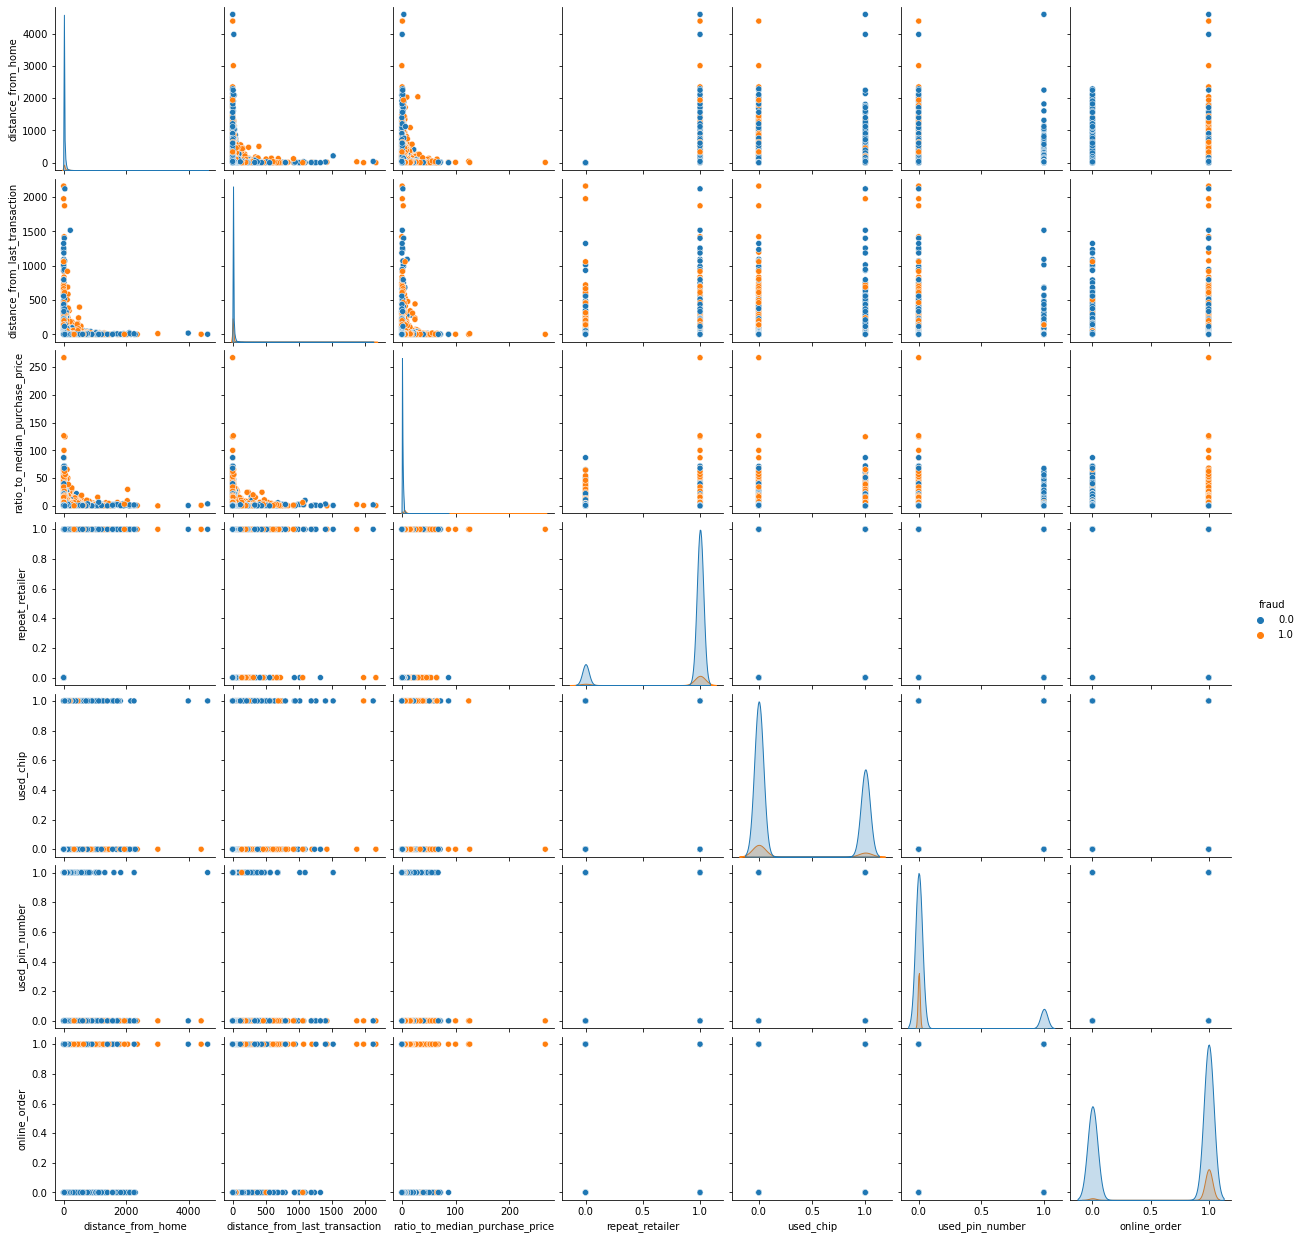

In [5]:
sb.pairplot(creditCard_data.dropna(), hue='fraud')
;

Analisando os gráficos verificamos que existem alguns 'outliers', que poderão ser cortados dos dados. Não encontramos erros de input nos dados.
Assim concluimos que não será necessário fazer pre-processamento e correção dos dados. Observando-se
superficialmente a divisão de classes podemos identificar imediatamente algumas condições que indicam a possível
presença de fraude:
 - A order ser feita online
 - O pin number não ser usado
 - Ratio to median price elevado


In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sb

creditCard_data = pd.read_csv('card_transdata.csv')
creditCard_data.loc[(creditCard_data['distance_from_home'] > 300),
              'distance_from_home'] = 300
creditCard_data.loc[(creditCard_data['distance_from_last_transaction'] > 50),
              'distance_from_last_transaction'] = 50
creditCard_data.loc[(creditCard_data['ratio_to_median_purchase_price'] > 25),
              'ratio_to_median_purchase_price'] = 25

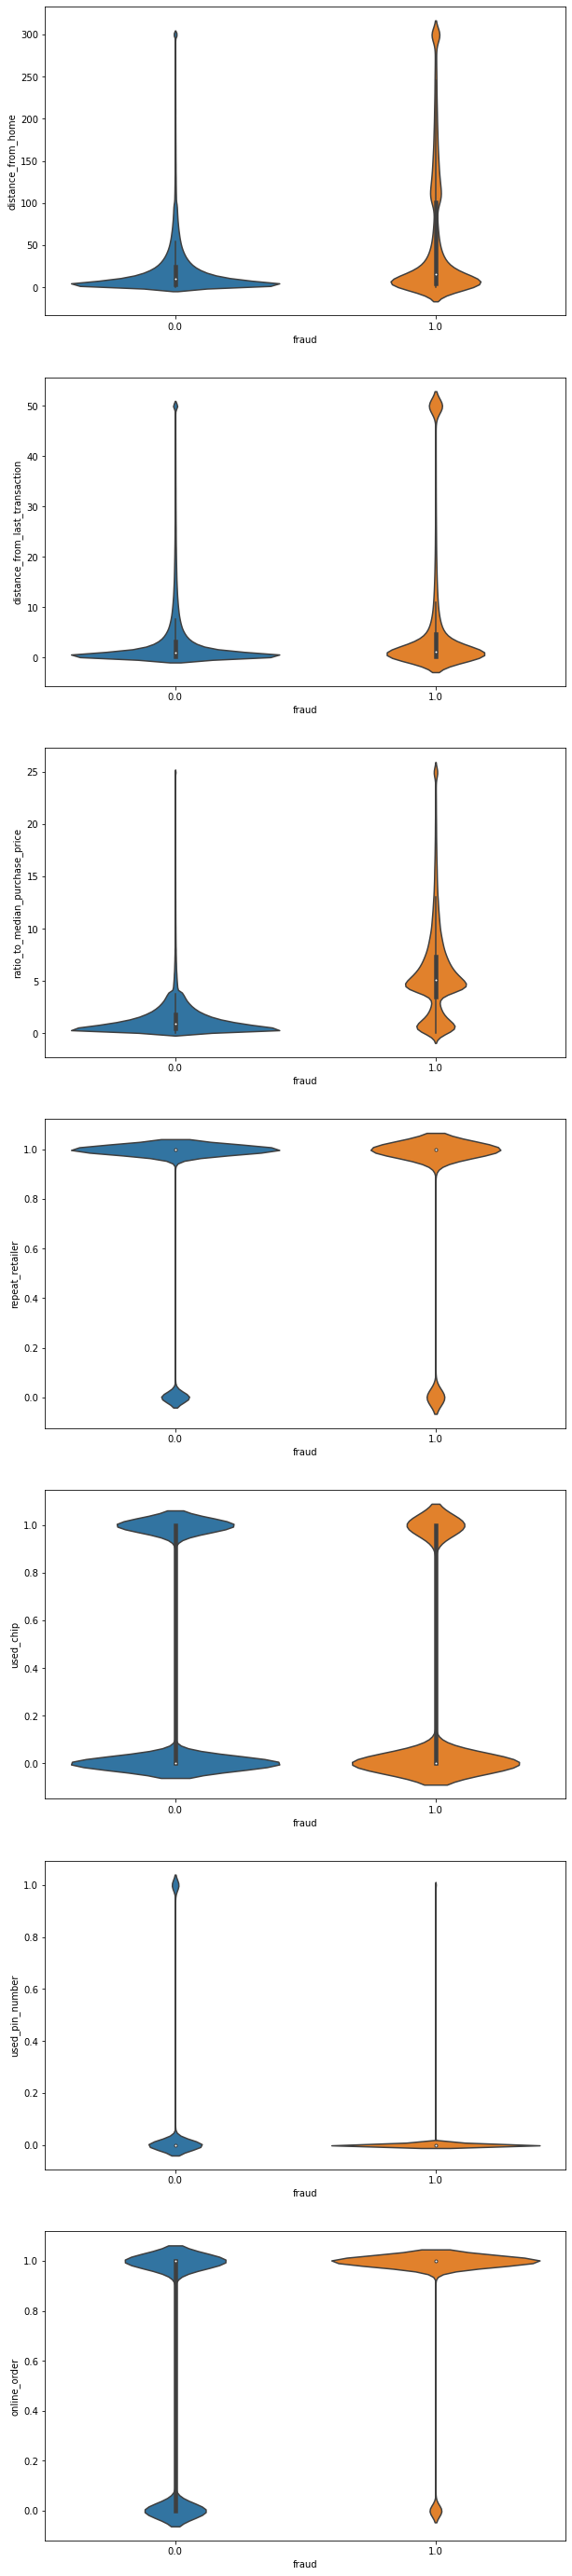

In [7]:
plt.figure(figsize=(10, 50))

for column_index, column in enumerate(creditCard_data.columns):
    if column == 'fraud':
        continue
    plt.subplot(7, 1, column_index + 1)
    sb.violinplot(x='fraud', y=column, data=creditCard_data)

Após termos limitado os 'outliers' a valores máximos e utilizando um método diferente de apresentação dos dados, é possível analisarmos com mais facilidade algumas correlações com fraude: distance_from_home, distance_from_last_transaction, ratio_to_median_purchase crescentes, used_pin_number a 0 e online_order a 1.

In [8]:
all_inputs = creditCard_data[['distance_from_home', 'distance_from_last_transaction',
                             'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']].values

all_labels = creditCard_data['fraud'].values 

In [9]:
from sklearn.model_selection import train_test_split

(training_inputs, testing_inputs, training_classes, testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25, random_state=42)

Os dados estão agora preparados para treinar um modelo e consequentemente testá-lo. Criámos um segundo set de dados que apenas contem casos de fraude de forma a podermos avaliar com mais eficácia a 'accuracy' do algoritmo em detetar apenas casos de fraude, que são, por motivos óbvios, os mais importantes de serem mais eficazmente detetados. Iremos começar pelo algoritmo **Decision Trees**:

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(training_inputs, training_classes)
decision_tree_classifier.score(testing_inputs, testing_classes)

0.999996

Obtivemos uma accuracy neste modelo superior a 99,99% (!), o que é estranhamente alto e poderá dever-se ao facto de a testing data ser predominantemente não fraude: se assumissemos por exemplo que 10% do nosso testing set são fraudes, se o nosso modelo fosse um 'dummy model' e optasse sempre por apontar uma compra como não fraude apenas obteria uma accuracy de 90%. Para avaliar o modelo será preciso ter em contra outras avaliações, por exemplo, precision e recall.

In [11]:
from collections import Counter
Counter(testing_classes)

Counter({0.0: 228258, 1.0: 21742})

Através do Counter, verifica-se apenas 10% dos dados de teste são fraude, confirmando que a accuracy não será a maneira mais adequada de testar a certidão do modelo.

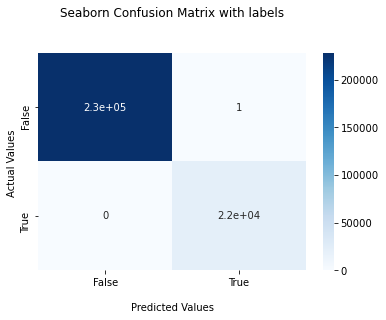

In [12]:
from sklearn.metrics import confusion_matrix
y_test_predict = decision_tree_classifier.predict(testing_inputs)
cf = confusion_matrix(testing_classes, y_test_predict)
ax = sb.heatmap(cf, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

In [13]:
print("The precision for Tree is ",precision_score(testing_classes, y_test_predict)) 
print("The recall for Tree is ",recall_score(testing_classes, y_test_predict),"\n")  

The precision for Tree is  0.9999540081865428
The recall for Tree is  1.0 



Tanto a precision como o recall deste output de dados são quase perfeitos, o que em conjunto com uma accuracy igualmente elevada, comprova a grande utilidade deste algoritmo neste problema específico.
Verifiquemos ainda assim a accuracy do nosso modelo utilizando diferentes testing e training sets:

''

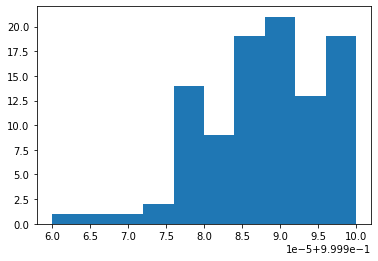

In [14]:
model_accuracies = []


for repetition in range(100):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25)
    
    decision_tree_classifier = DecisionTreeClassifier()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_accuracies.append(classifier_accuracy)


plt.hist(model_accuracies)
;

Podemos chegar assim à conclusão que o Decision Trees é um ótimo algoritmo de forma a fazer predições com a quantidade e o tipo de dados que possuímos, não havendo assim necessidade nenhuma de fazer ajustes aos parâmetros do mesmo. Acreditamos que a alta eficácia deste algoritmo poderá dever-se ao elevado número de dados fornecidos (1 000 000).

In [15]:
import sklearn.tree as tree

decision_tree_classifier.fit(training_inputs, training_classes)
with open('creditcardtree.dot', 'w') as out_file:
    out_file = tree.export_graphviz(decision_tree_classifier, out_file=out_file)

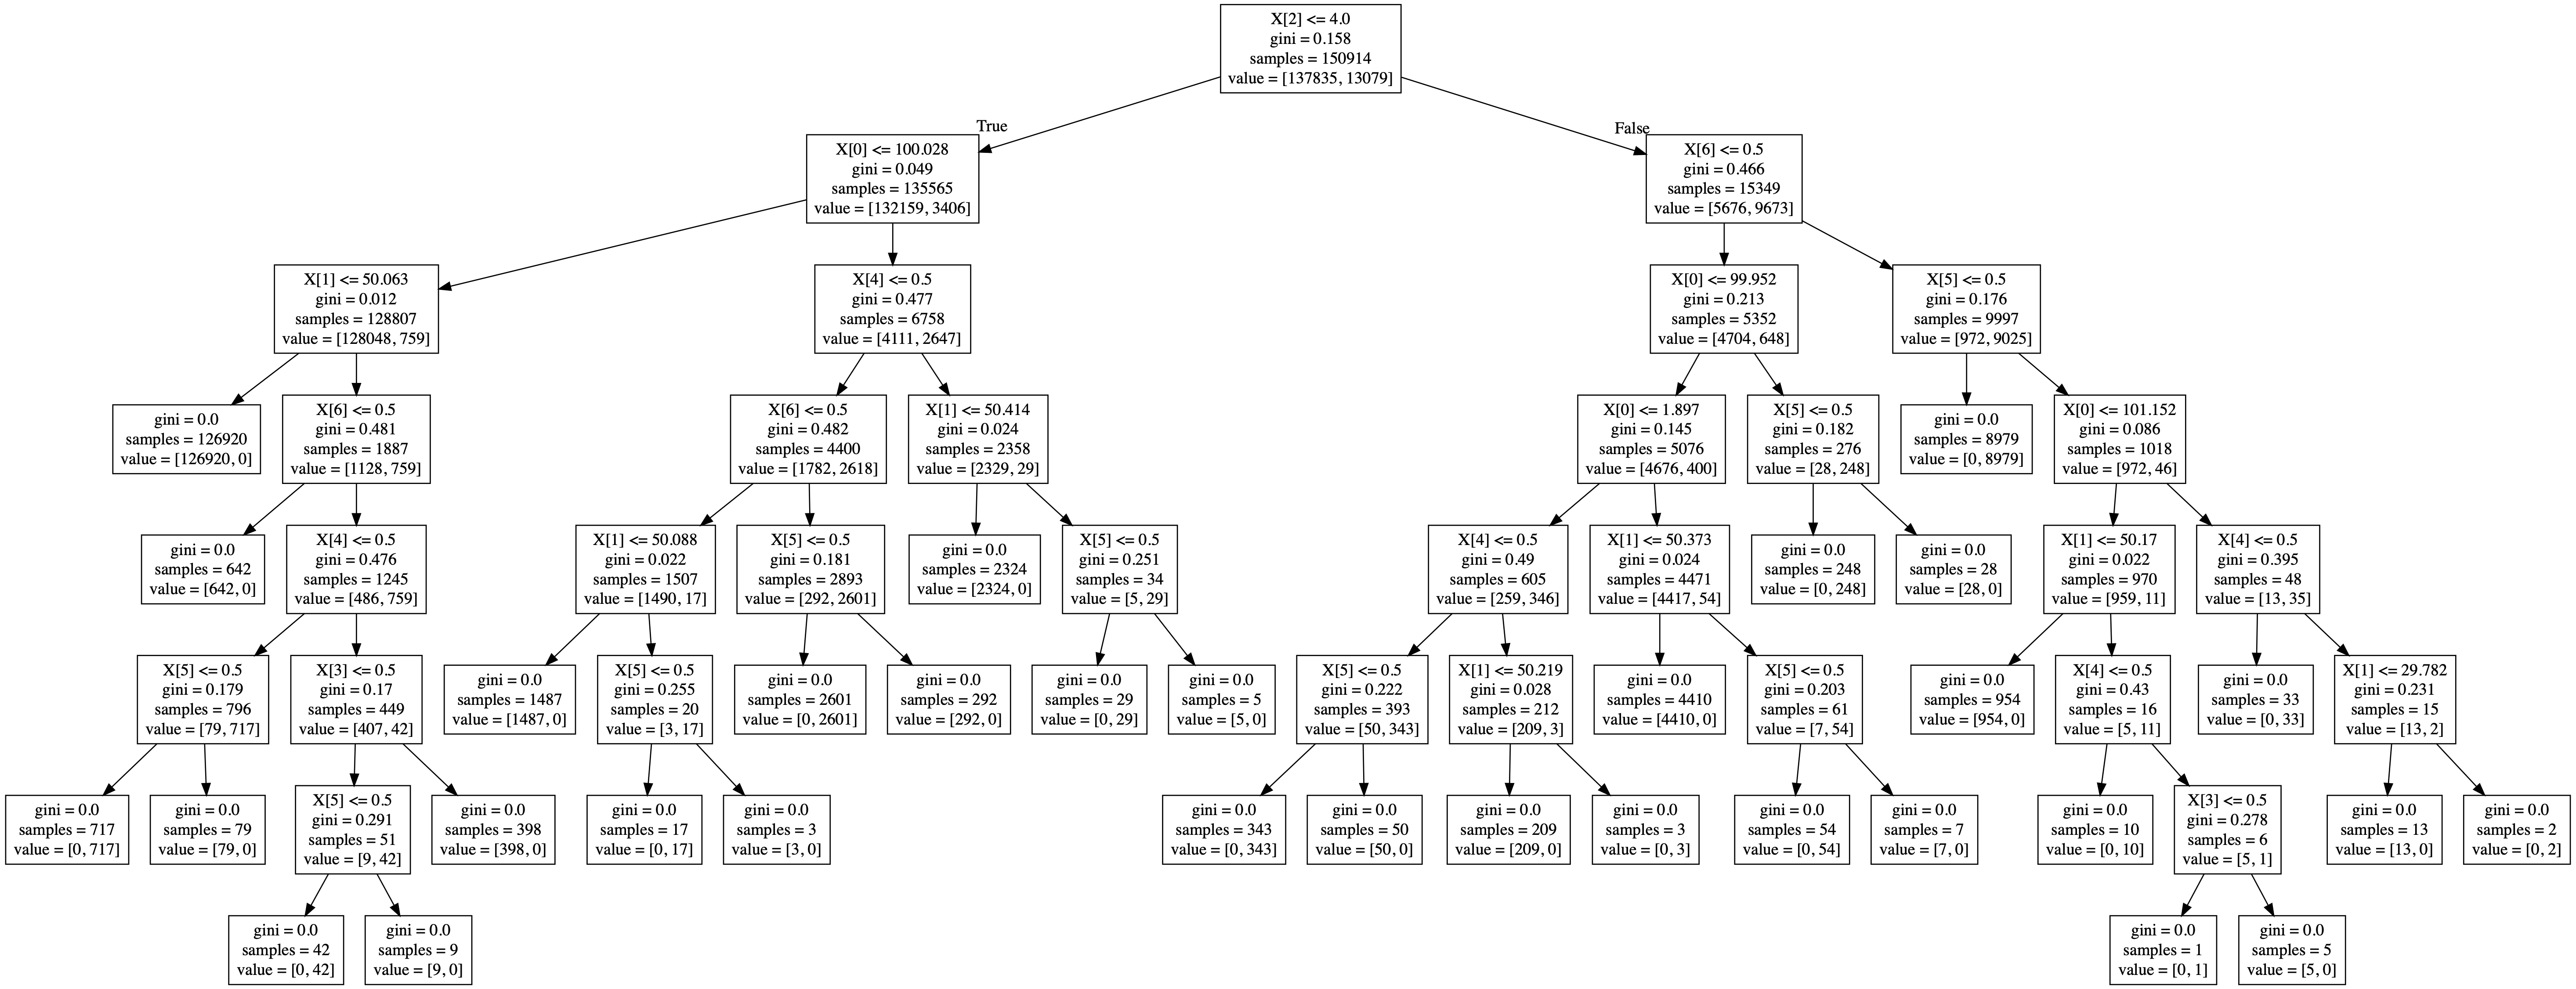

Esta é a Classification Tree final obtida pelo nosso modelo.

Testaremos agora com o algoritmo **Naive Bayes**:

In [16]:
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(training_inputs,training_classes)
gnb.score(testing_inputs, testing_classes)

0.940968

Os resultados não são tão impressionantes quanto os resultados do Decision Trees, no entanto, não deixa de ser uma eficácia suficientemente alta para o Naive Bayes ser um algoritmo a ter em consideração para o problema apresentado.

''

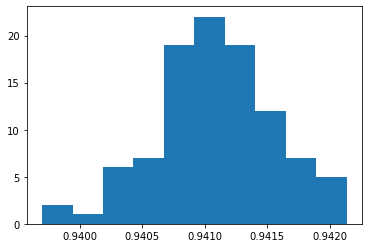

In [17]:
model_accuracies1 = []


for repetition in range(100):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25)
    
    gnb = GaussianNB()
    gnb.fit(training_inputs,training_classes)    
    classifier_accuracy1 = gnb.score(testing_inputs, testing_classes)
    model_accuracies1.append(classifier_accuracy1)


plt.hist(model_accuracies1)
;

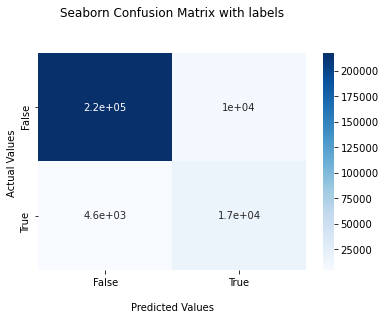

In [18]:
y_test_predict1 = gnb.predict(testing_inputs)
cf1 = confusion_matrix(testing_classes, y_test_predict1)
ax = sb.heatmap(cf1, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show() 

In [19]:
print("The precision for NB is ",precision_score(testing_classes, y_test_predict1)) 
print("The recall for NB is ",recall_score(testing_classes, y_test_predict1),"\n") 

The precision for NB is  0.6332402133294635
The recall for NB is  0.7927150513216459 



Apesar de a 'accuracy' deste algoritmo parecer favorável, tanto a precisão como o recall do mesmo demonstram o contrário: o algoritmo retorna um número significativo de compras fraudulentas como legitimas (recall ~80%) e de compras legitimas como sendo fraudulentas (precision ~60%), que sendo o que mais tentamos evitar, torna este algoritmo indesejável e pouco útil para este propósito.

Testaremos agora com o algoritmo **Logistic Regression**:

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(training_inputs,training_classes)

pipe.score(testing_inputs, testing_classes)

0.958512

De forma a conseguirmos correr este algoritmo com os dados que nos foram fornecidos, rapidamente percebemos que teríamos de ajustar parte dos dados fornecidos (removendo alguns outliers, entre outros ajustes...), de forma a que este algoritmo corra dentro de um número de iterações computacionalmente aceitáveis. Este ajuste é realizado pelo StandardScaler. Desta forma, obtivemos uma accuracy de cerca de 96%.

''

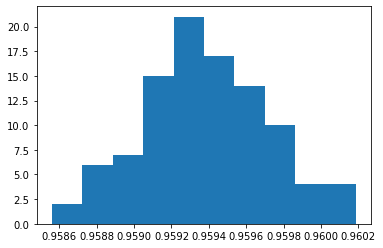

In [21]:
model_accuracies2 = []


for repetition in range(100):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25)
    
    pipe = make_pipeline(StandardScaler(), LogisticRegression())
    pipe.fit(training_inputs,training_classes)
    classifier_accuracy2 = pipe.score(testing_inputs, testing_classes)
    model_accuracies2.append(classifier_accuracy2)


plt.hist(model_accuracies2)
;

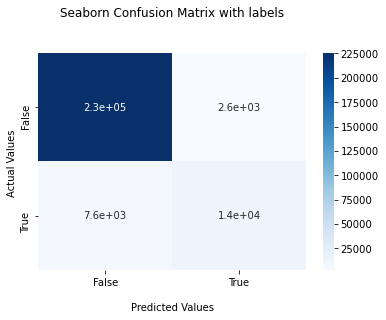

In [22]:
y_test_predict2 = pipe.predict(testing_inputs)
cf2 = confusion_matrix(testing_classes, y_test_predict2)
ax = sb.heatmap(cf2, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show() 

In [23]:
print("The precision for LR is ",precision_score(testing_classes, y_test_predict2)) 
print("The recall for LR is ",recall_score(testing_classes, y_test_predict2),"\n") 

The precision for LR is  0.8457545199594247
The recall for LR is  0.6520979020979021 



Assim sendo, apesar de não ser ideal, Logistic Regression demonstra, comparado com Naive Bayes, mais precision, mas menos recall: marcará menos casos de não fraude como fraude, mas deixará mais casos de fraude escapar, o que poderá ser desejado ou não, dependendo do objetivo do sistema.

In [24]:
pipe1 = make_pipeline(StandardScaler(), LogisticRegression(penalty = 'none', max_iter = 10000))
pipe1.fit(training_inputs,training_classes)

pipe1.score(testing_inputs, testing_classes)

0.959412

In [25]:
y_test_predict3 = pipe1.predict(testing_inputs)
print("Confusion Matrix LR : \n", confusion_matrix(testing_classes, y_test_predict3),"\n")
print("The precision for LR is ",precision_score(testing_classes, y_test_predict3)) 
print("The recall for LR is ",recall_score(testing_classes, y_test_predict3),"\n") 

Confusion Matrix LR : 
 [[225679   2585]
 [  7562  14174]] 

The precision for LR is  0.8457545199594247
The recall for LR is  0.6520979020979021 



''

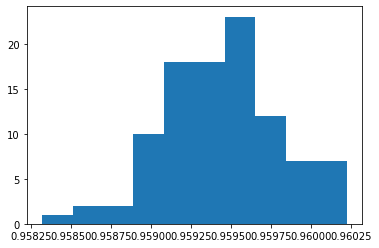

In [26]:
model_accuracies3 = []


for repetition in range(100):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25)
    
    pipe1 = make_pipeline(StandardScaler(), LogisticRegression(penalty = 'none', max_iter = 10000))
    pipe1.fit(training_inputs,training_classes)
    classifier_accuracy3 = pipe1.score(testing_inputs, testing_classes)
    model_accuracies3.append(classifier_accuracy3)


plt.hist(model_accuracies3)
;

Tentamos alterar alguns parâmetros deste algoritmo uma vez que suspeitávamos que com uma penalidade de erro mais acertada ou com um maior numero de iterações poderia tornar o algoritmo útil para o problema, no entanto, não sucedemos e nenhuma alteração dos parâmetros parece alterar substancialmente a performance do algoritmo.